<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Custom%20Datasets/Pytorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 4 of the Pytorch for DeepLearning Bootcamp from ZTM

This section is for how you use you custom datasets with Pytorch

## 0. Importing Pytorch and set up device agnostic code

In [1]:
import torch
from torch import nn

#Note: Pytorch 1.10.0 + is required
torch.__version__

'2.4.1+cu121'

In [2]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data
Our dataset is a subset of the Food 101 dataset.
The Food dataset starts with 101 different class and 1000 images per class
Our dataset starts with 3 classes of food and only 10% of the images

In [3]:
import requests
import zipfile
from pathlib import Path

#setuo path to a folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the foldere doesn't exist download it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} doesn't exists... creating one")
  image_path.mkdir(parents=True, exist_ok=True)

#Downloading it
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading dataset from github")
  f.write(requests.content)

#unzip it
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping it")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi doesn't exists... creating one
unzipping it


## 2. Data preparation and data exploration

In [4]:
import os

def walkthrough_dir(dir_path):
  """walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

walkthrough_dir(image_path)


There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi
There are 0 directories and 75 images in data/pizza_steak_sushi
There are 0 directories and 72 images in data/pizza_steak_sushi
There are 0 directories and 78 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi
There are 0 directories and 19 images in data/pizza_steak_sushi
There are 0 directories and 31 images in data/pizza_steak_sushi
There are 0 directories and 25 images in data/pizza_steak_sushi


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing a image

Let's ride some code to:
1. Get all of the image paths
2. Pick a rando image path using random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Open the image with Pillow

Random image path: data/pizza_steak_sushi/train/pizza/2451169.jpg
Image class: 2451169
Image height: 512
Image width: 512


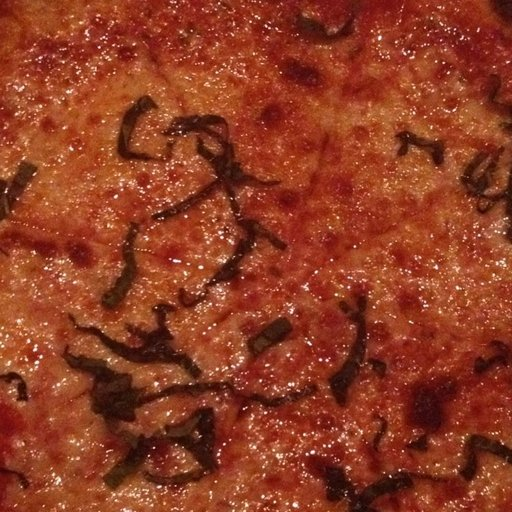

In [6]:
import random
from PIL import Image

#Set seed
#random.seed(42)

# 1. Get the paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a rando image
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name (the class is the name of the directory)
image_class = random_image_path.stem

# 4. OPen image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

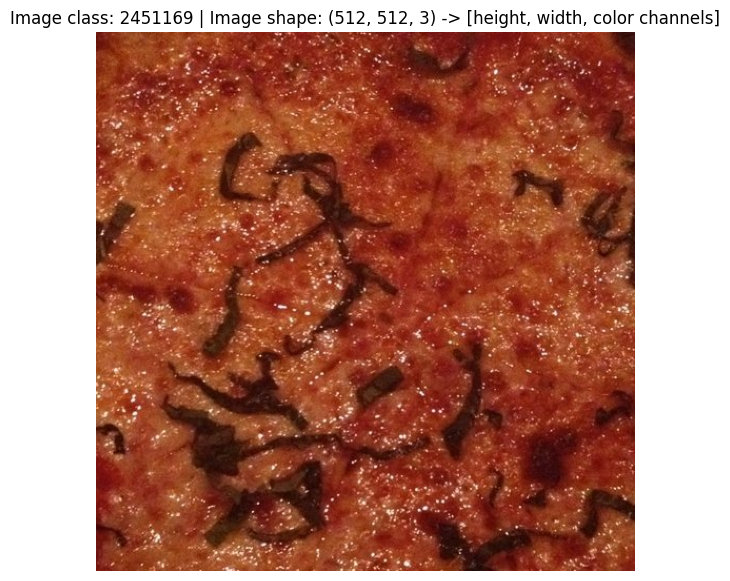

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into an array
img_as_array = np.asarray(img)
#Plot the image with Matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

## 3. Transforming data
Before we can use our image data with Pytorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and a subsequently a `torch.utils.data.DataLoader`



In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torch.vision.transforms`

In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch tensor
    transforms.ToTensor()
  ])
data_transform(img)

tensor([[[0.2275, 0.2471, 0.3882,  ..., 0.5490, 0.5059, 0.4510],
         [0.2549, 0.3137, 0.4549,  ..., 0.5490, 0.4902, 0.4392],
         [0.3176, 0.4157, 0.5294,  ..., 0.5608, 0.5373, 0.5255],
         ...,
         [0.5882, 0.5804, 0.6549,  ..., 0.5490, 0.5373, 0.4706],
         [0.5490, 0.5725, 0.6275,  ..., 0.5647, 0.5490, 0.4941],
         [0.5098, 0.5373, 0.6078,  ..., 0.5647, 0.5412, 0.4980]],

        [[0.0745, 0.0706, 0.1216,  ..., 0.2078, 0.1569, 0.1098],
         [0.0745, 0.0863, 0.1569,  ..., 0.1961, 0.1412, 0.1020],
         [0.0824, 0.1255, 0.1843,  ..., 0.2000, 0.1882, 0.1804],
         ...,
         [0.2392, 0.2549, 0.3569,  ..., 0.2549, 0.2196, 0.1294],
         [0.1804, 0.2235, 0.2980,  ..., 0.2392, 0.2118, 0.1412],
         [0.1333, 0.1843, 0.2824,  ..., 0.2275, 0.1882, 0.1294]],

        [[0.0627, 0.0471, 0.0706,  ..., 0.0980, 0.0902, 0.0706],
         [0.0627, 0.0549, 0.0824,  ..., 0.0784, 0.0588, 0.0510],
         [0.0549, 0.0706, 0.0941,  ..., 0.0667, 0.0745, 0.

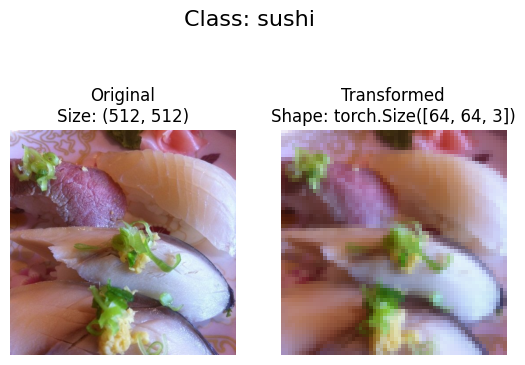

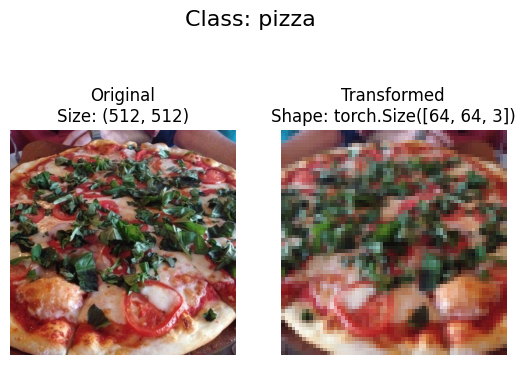

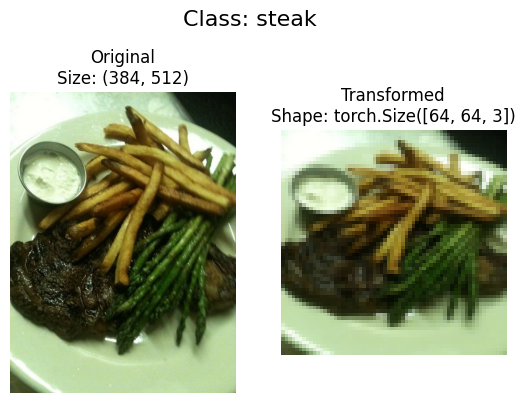

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects rrandom images from a path of images and loads/transfoms them then plots
  the original and the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  #going from (C, H, W) for (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


## 4.Loading image data using ` Image Folder`
###Option 1

We can load image classification data using `torchvision.datasets.ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
#get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [16]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image permute: torch.Size([64, 64, 3]) -> [H, W C]


Text(0.5, 1.0, 'pizza')

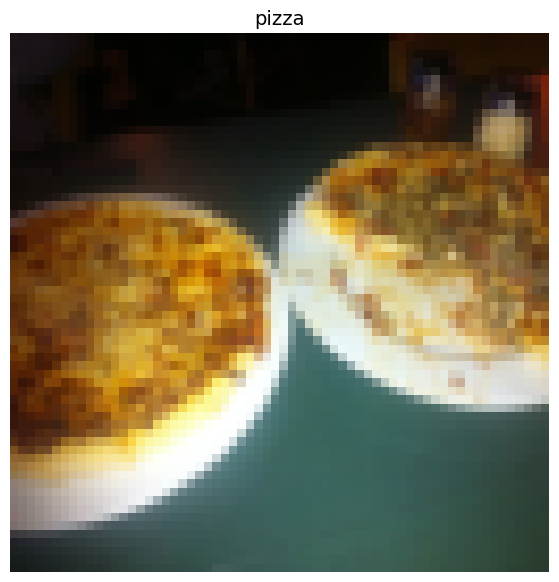

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

#print out different shapes
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image permute: {img_permute.shape} -> [H, W C]")

#Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into DataLoader`s
Using `torch.utils.data.DataLoader`to load data in batches

In [18]:
#Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 12

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

print(f"Using {len(train_dataloader)} batches of {BATCH_SIZE} images")


Using 19 batches of 12 images


In [19]:
img, label = next(iter(train_dataloader))

print(f"image shape {img.shape}")


image shape torch.Size([12, 3, 64, 64])


## 5 Option 2: Loading image data with a custom dataset
1. Able to load images from file
2. ABle to get class names from the dataset
3. Able to get classes as dictionary from the dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-built dataset functions

Cons:
* Even though you could create Dataset out of almost anything, it doesn't mean it will work
* Using a custom Dataset often results in us writing more code, wich could be prono to errors or performance issues


In [20]:
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [21]:
# Instance of torch.vision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using os.scandir() to traverse a target directory
2. Raise an error if the class names aren found
3. Turn the class names into a dict and a list and return them

In [22]:
#setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

#Get the class names from the tarhet directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldnt find any classes in {directory}... please check the file structure")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [24]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a cusom Dataset to replicate ImageFolder()

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd likje to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images()
5. Overwrite the __len()__ method to return the length of our dataset
6. Overwrite the __getitem()__ method to return a given sample when passed an index

In [25]:
# 0. write a custom dataset class

#1. #SUbclass torch.utils.dataset
class ImageFolderCustom(Dataset):
  #2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
      #3. Create class attributes
      #get all of the image paths
      self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

      #Setup transforms
      self.transform = transform
      # Create class and class_to_idx
      self.classes, self.class_to_idx = find_classes(targ_dir)

  #4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format data_folder/class_name/image.jpgg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx #return data, label (X, y)
    else:
      return img, class_idx #return untransformed image and label

In [26]:
img, label = train_data[0]

In [27]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


In [28]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                   transform=test_transforms)

In [29]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [30]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [31]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [32]:
# Check for equality between original ImageFolder Dataset and ours
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a dataset and a number of other parameters such as many images to
visualize.

2. TO prevent the display getting out of hand = 10,

3. Set the random seed for reproducibility

4. Get a list of random samples indexes from the target dataset

5. Setup a matplotlib plot

6. Loop through the random sample images and plot them with matplotlib

7. Make sure the dimensions of our images line up with matplotlib(HWC)

In [33]:
# 1. create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjuts display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f" For display purposes, n shouldn't be larger than 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4.Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. set the plot
  plt.figure(figsize=(16, 8))
  # 6. Loop through random indexes and plot with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)  #[C, H, W] -> [H, W, C]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


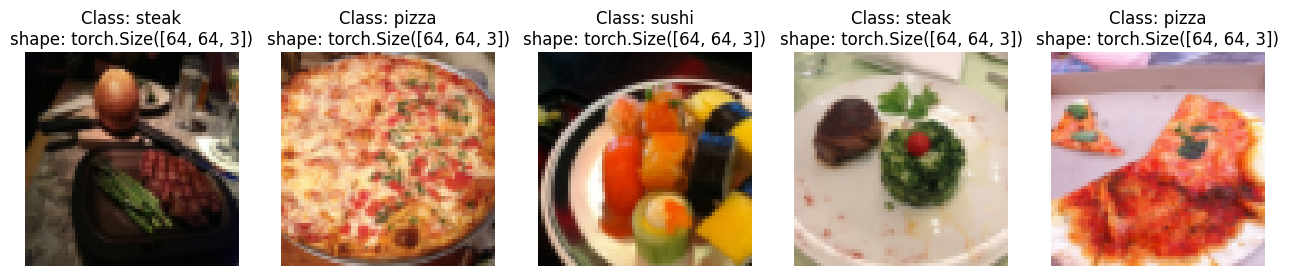

In [34]:
#display random images from the ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

 For display purposes, n shouldn't be larger than 10


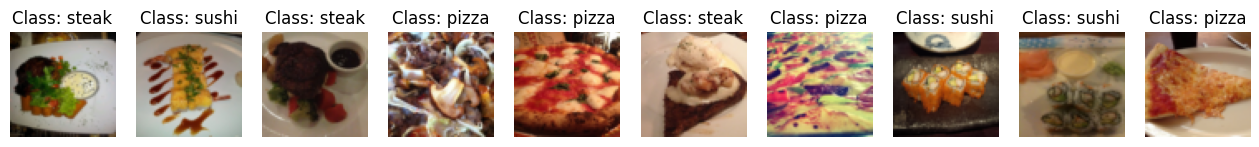

In [35]:
#Display random images from the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded imagens into Dataloader

In [36]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c32b8a238b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c32b8a23b50>)

In [37]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

#print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms(data augmentation)

Adding diversity to the training data

In [38]:
# Let's look at Trivia Augment
from torchvision import transforms

train_transforms = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor()

])

In [39]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/443210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1787505.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3727036.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2129685.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/165639.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/830007.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/256592.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1621763.jpg')]

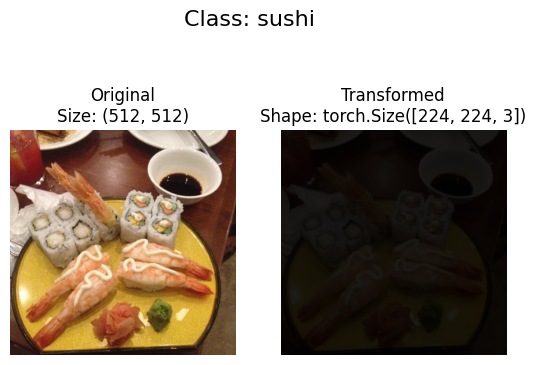

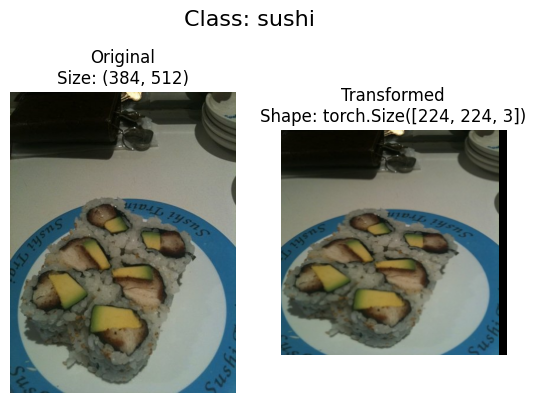

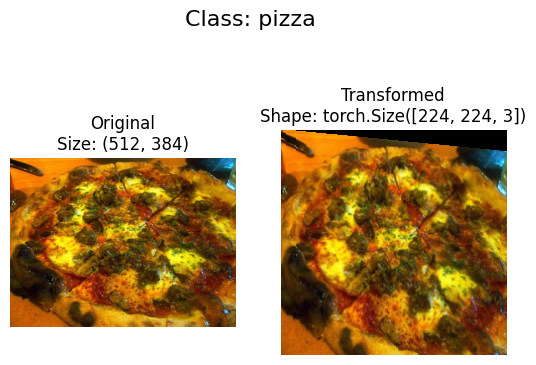

In [40]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None

)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [41]:
#Create simple transform
simple_transform = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
])

In [42]:
# 1. LOad and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)

### 7.2 Create TinyVGG model class

In [63]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a foward pass on a single image (to test the model)


In [44]:
#get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [45]:
#Try a foward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use torchinfo to get an idea of the shapes going through our mode

In [46]:
#install torchinfo and import if is available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create a train and test loop functions

* train_step() - takes in a model and dataloader and trains the model on the dataloader
* test_step() - takes in a model and dataloader and evaluates the model on the dataloader

In [47]:
#Create a train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  #put the model in train mode
  model.train()

  #setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  #Loop through dataloader data batches
  for batch, (X, y) in enumerate(dataloader):
    #send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Foward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. LOss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc



In [48]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Creating a train function to combine train_step() and test_step()

In [49]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate model 0

In [50]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0807 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0843 | train_acc: 0.4023 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4102 | test_loss: 1.0655 | test_acc: 0.5644
Total training time: 9.918 seconds


In [51]:
model_0_results

{'train_loss': [1.1063191443681717,
  1.0998065173625946,
  1.0868552029132843,
  1.0843387693166733,
  1.0662569254636765],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41015625],
 'test_loss': [1.0983210404713948,
  1.0696895122528076,
  1.080726146697998,
  1.0608044068018596,
  1.0655126174290974],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves

In [52]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [53]:
def plot_loss_curves(results: Dict[str, List[float]]):


  #Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  #Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot the Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

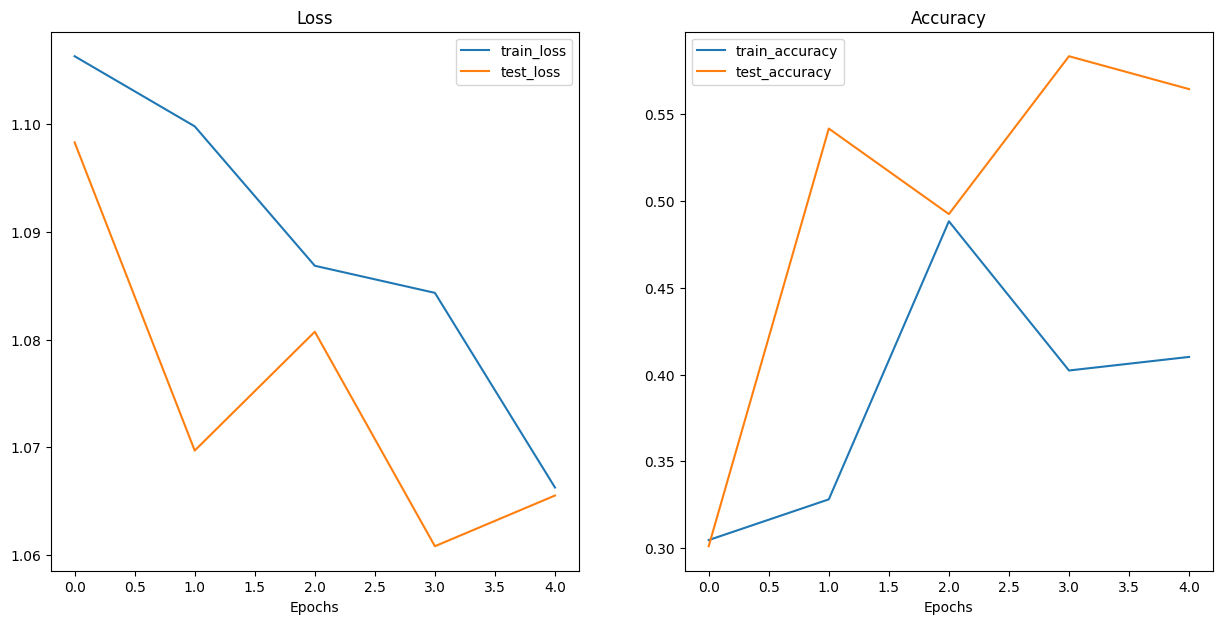

In [54]:
plot_loss_curves(model_0_results)

## 9. Model q: TinyVGG with data augmentation

### 9.1 Create transform with data augmentation

In [55]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64,64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()

])
test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

### 9.2 Create train and test Datasets and DataLoadeers with data augmentation

In [56]:
#turn image folders into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [57]:
# Turn ourm datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS= os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)



### 9.3 Construct and train model 1

In [59]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [64]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2146 | train_acc: 0.3047 | test_loss: 1.1597 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1070 | train_acc: 0.3047 | test_loss: 1.1231 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0982 | train_acc: 0.3047 | test_loss: 1.1030 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0954 | train_acc: 0.3047 | test_loss: 1.0907 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0941 | train_acc: 0.5273 | test_loss: 1.0821 | test_acc: 0.5417
Total training time for model_1: 5.610 seconds


### 9.4 Plot the loss curves of model 1

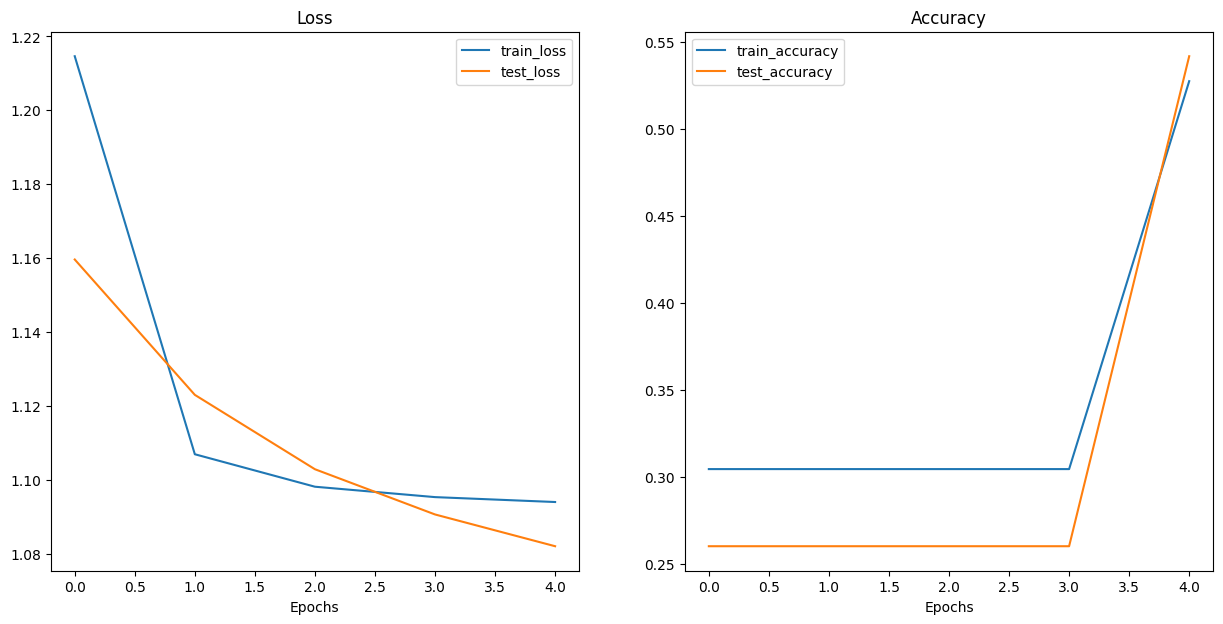

In [66]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [68]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099807,0.328125,1.069690,0.541667
2,1.086855,0.488281,1.080726,0.492424
3,1.084339,0.402344,1.060804,0.583333
4,1.066257,0.410156,1.065513,0.564394


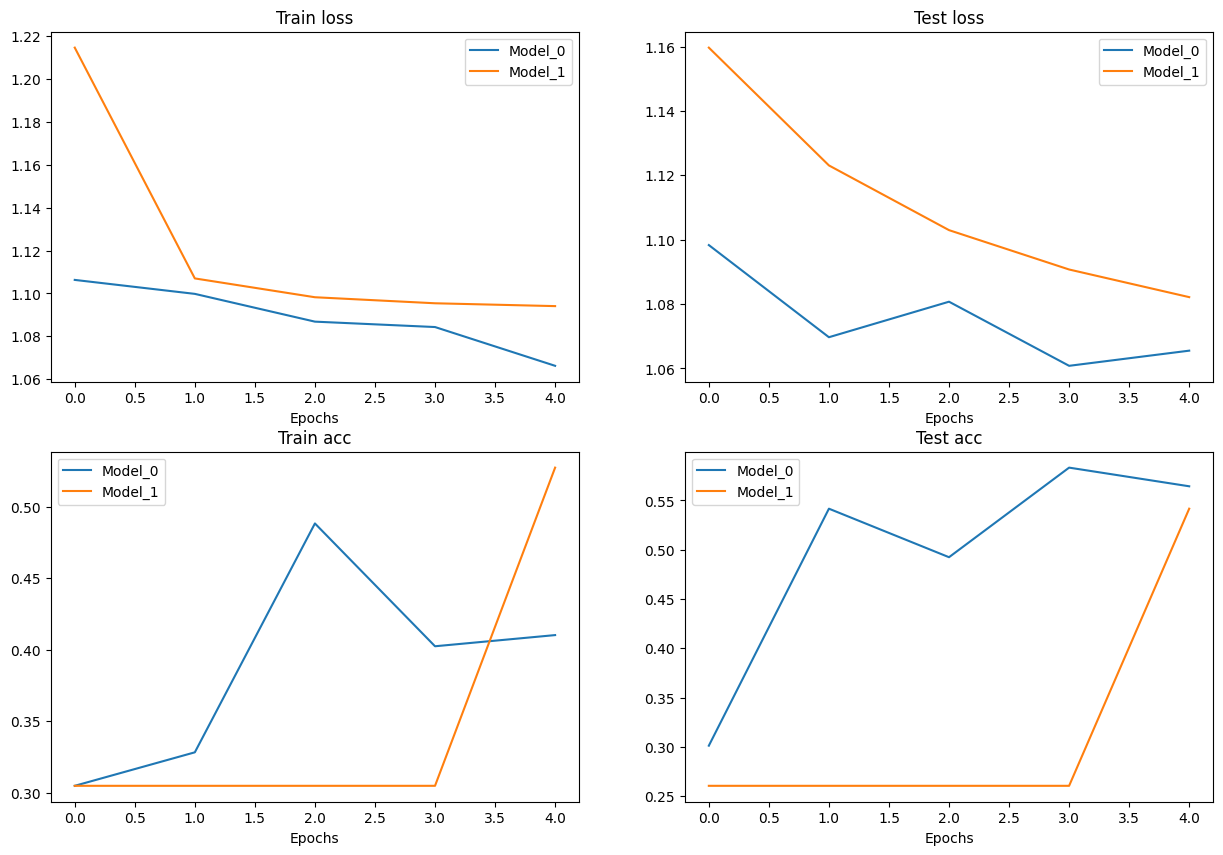

In [73]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get numer of epochs
epochs = range(len(model_0_df))

#Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label="Model_0")
plt.plot(epochs, model_1_df['train_loss'], label="Model_1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

#Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label="Model_0")
plt.plot(epochs, model_1_df['test_loss'], label="Model_1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

#Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label="Model_0")
plt.plot(epochs, model_1_df['train_acc'], label="Model_1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()

#Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label="Model_0")
plt.plot(epochs, model_1_df['test_acc'], label="Model_1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

In [74]:
#  Download a custom image
import requests

#setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
     # When downloading from Github, need to use the raw file link
     request = requests.get("https://rawgithubusercontent.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg")
     print(f"Downloading {custom_image_path}...")
     f.write(request.content)

else:
  print(f"{custom_image_path} already exists, skipping download")